<a href="https://colab.research.google.com/github/dvw4/Project/blob/Milestone2/Milestone2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#downloading dataset in google drive
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/SemanticSegmentation"
%cd /content/gdrive/My Drive/SemanticSegmentation 
! kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery

Mounted at /content/gdrive


In [ ]:
!unzip semantic-segmentation-of-aerial-imagery.zip

Archive:  semantic-segmentation-of-aerial-imagery.zip
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_001.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_002.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_003.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_004.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_005.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_006.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_007.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_008.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_009.jpg  
  inflating: Semantic segmentation dataset/Tile 1/masks/image_part_001.png  
  inflating: Semantic segmentation dataset/Tile 1/masks/image_part_002.png  
  inflating: Semantic segmentation dataset/Tile 1/masks/image_part_003.png  
  inflating: 

In [ ]:
ls -a

 kaggle.json                       semantic-segmentation-of-aerial-imagery.zip
'Semantic segmentation dataset'/


In [ ]:
%cd project/Project

/content/gdrive/MyDrive/project/Project


In [ ]:
!git checkout main
!git checkout -b Milestone2

Already on 'main'
Your branch is up to date with 'origin/main'.
Switched to a new branch 'Milestone2'


In [ ]:
!git status

On branch Milestone2
nothing to commit, working tree clean


In [ ]:
ls -a

'Copy of 228_training_aerial_imagery.py'   README.md
 .git/                                     simple_multi_unet_model.py
 NNI.jpg


Segmentation Models: using `keras` framework.
Traceback (most recent call last):
  File "Copy of 228_training_aerial_imagery.py", line 129, in <module>
    plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
IndexError: index 0 is out of bounds for axis 0 with size 0


Now patchifying image: /content/gdrive/My Drive/SemanticSegmentation/Semantic segmentation dataset/Tile 1/images/image_part_002.jpg
Now patchifying image: /content/gdrive/My Drive/SemanticSegmentation/Semantic segmentation dataset/Tile 1/images/image_part_008.jpg
Now patchifying image: /content/gdrive/My Drive/SemanticSegmentation/Semantic segmentation dataset/Tile 1/images/image_part_006.jpg
Now patchifying image: /content/gdrive/My Drive/SemanticSegmentation/Semantic segmentation dataset/Tile 1/images/image_part_003.jpg
Now patchifying image: /content/gdrive/My Drive/SemanticSegmentation/Semantic segmentation dataset/Tile 1/images/image_part_004.jpg
Now patchifying image: /content/gdrive/My Drive/SemanticSegmentation/Semantic segmentation dataset/Tile 1/images/image_part_009.jpg
Now patchifying image: /content/gdrive/My Drive/SemanticSegmentation/Semantic segmentation dataset/Tile 1/images/image_part_005.jpg
Now patchifying image: /content/gdrive/My Drive/SemanticSegmentation/Semanti

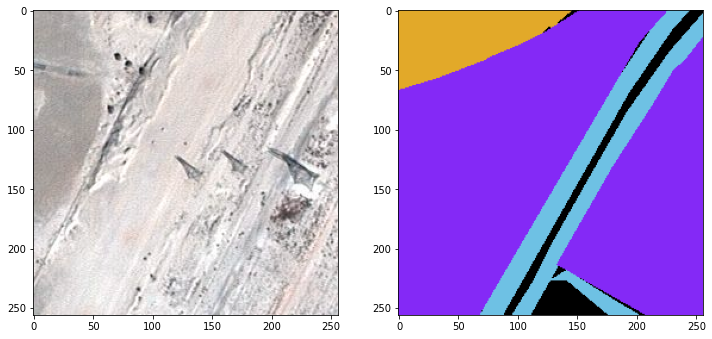

60
Unique labels in label dataset are:  [0 1 2 3 4 5]


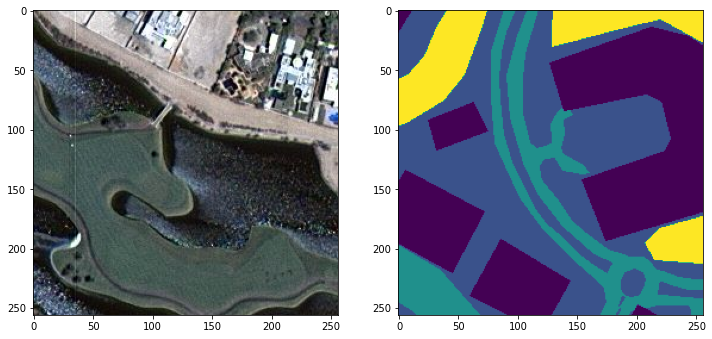

In [ ]:
# https://youtu.be/jvZm8REF2KY
"""
Explanation of using RGB masks: https://youtu.be/sGAwx4GMe4E

https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery

The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The total volume of the dataset is 72 images grouped into 6 larger tiles. The classes are:

Building: #3C1098
Land (unpaved area): #8429F6
Road: #6EC1E4
Vegetation: #FEDD3A
Water: #E2A929
Unlabeled: #9B9B9B

Use patchify....
Tile 1: 797 x 644 --> 768 x 512 --> 6
Tile 2: 509 x 544 --> 512 x 256 --> 2
Tile 3: 682 x 658 --> 512 x 512  --> 4
Tile 4: 1099 x 846 --> 1024 x 768 --> 12
Tile 5: 1126 x 1058 --> 1024 x 1024 --> 16
Tile 6: 859 x 838 --> 768 x 768 --> 9
Tile 7: 1817 x 2061 --> 1792 x 2048 --> 56
Tile 8: 2149 x 1479 --> 1280 x 2048 --> 40
Total 9 images in each folder * (145 patches) = 1305
Total 1305 patches of size 256x256

"""

import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

root_directory = os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/SemanticSegmentation"

patch_size = 256

#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)
                
  
                
  
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()
###########################################################################
"""
RGB to HEX: (Hexadecimel --> base 16)
This number divided by sixteen (integer division; ignoring any remainder) gives 
the first hexadecimal digit (between 0 and F, where the letters A to F represent 
the numbers 10 to 15). The remainder gives the second hexadecimal digit. 
0-9 --> 0-9
10-15 --> A-F

Example: RGB --> R=201, G=, B=

R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)

Calculating RGB from HEX: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 0 = 16
98 = 9*16 + 8 = 152

"""
#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60. 
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()


############################################################################

n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)


#######################################
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]




In [ ]:
%cd gdrive/MyDrive/project/Project




/content/gdrive/MyDrive/project/Project


In [ ]:
from simple_multi_unet_model import multi_unet_model, jacard_coef  

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

In [ ]:
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=20, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/20
66/66 [==============================] - 14s 191ms/step - loss: 1.0162 - accuracy: 0.4953 - jacard_coef: 0.1604 - val_loss: 1.0115 - val_accuracy: 0.5273 - val_jacard_coef: 0.1485
Epoch 2/20
66/66 [==============================] - 12s 182ms/step - loss: 1.0097 - accuracy: 0.5304 - jacard_coef: 0.1787 - val_loss: 1.0079 - val_accuracy: 0.5279 - val_jacard_coef: 0.1622
Epoch 3/20
66/66 [==============================] - 12s 184ms/step - loss: 1.0080 - accuracy: 0.5296 - jacard_coef: 0.1819 - val_loss: 1.0052 - val_accuracy: 0.5352 - val_jacard_coef: 0.1750
Epoch 4/20
66/66 [==============================] - 12s 185ms/step - loss: 1.0071 - accuracy: 0.5316 - jacard_coef: 0.1849 - val_loss: 1.0047 - val_accuracy: 0.5300 - val_jacard_coef: 0.1756
Epoch 5/20
66/66 [==============================] - 12s 183ms/step - loss: 1.0065 - accuracy: 0.5312 - jacard_coef: 0.1863 - val_loss: 1.0042 - val_accuracy: 0.5297 - val_jacard_coef: 0.1786
Epoch 6/20
66/66 [===========================

In [ ]:
model.save('models/satellite_standard_unet_100epochs_7May2021.hdf5')
############################################################

In [ ]:
#TRY ANOTHE MODEL - WITH PRETRINED WEIGHTS
#Resnet backbone
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

# define model
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

# compile keras model with defined optimozer, loss and metrics
#model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

print(model_resnet_backbone.summary())

85521592/85521592 [==============================] - 5s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                           

In [ ]:
history2=model_resnet_backbone.fit(X_train_prepr, 
          y_train,
          batch_size=16, 
          epochs=20,
          verbose=1,
          validation_data=(X_test_prepr, y_test))

Epoch 1/20
66/66 [==============================] - 28s 325ms/step - loss: 1.4439 - accuracy: 0.4950 - jacard_coef: 0.1893 - val_loss: 9.8435 - val_accuracy: 0.1360 - val_jacard_coef: 0.0747
Epoch 2/20
66/66 [==============================] - 18s 277ms/step - loss: 1.3250 - accuracy: 0.5312 - jacard_coef: 0.2129 - val_loss: 125.2757 - val_accuracy: 0.5212 - val_jacard_coef: 0.3489
Epoch 3/20
66/66 [==============================] - 18s 277ms/step - loss: 1.3120 - accuracy: 0.5299 - jacard_coef: 0.2216 - val_loss: 1.4252 - val_accuracy: 0.5280 - val_jacard_coef: 0.1686
Epoch 4/20
66/66 [==============================] - 18s 274ms/step - loss: 1.3035 - accuracy: 0.5328 - jacard_coef: 0.2219 - val_loss: 6.6449 - val_accuracy: 0.5216 - val_jacard_coef: 0.3294
Epoch 5/20
66/66 [==============================] - 18s 273ms/step - loss: 1.2945 - accuracy: 0.5332 - jacard_coef: 0.2244 - val_loss: 3.5097 - val_accuracy: 0.1685 - val_jacard_coef: 0.1189
Epoch 6/20
66/66 [=========================

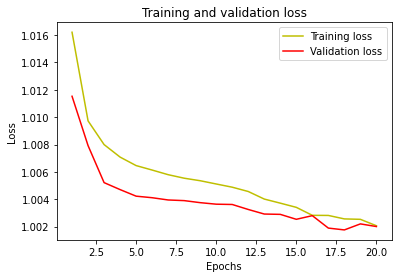

In [ ]:
#plot the training and validation accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

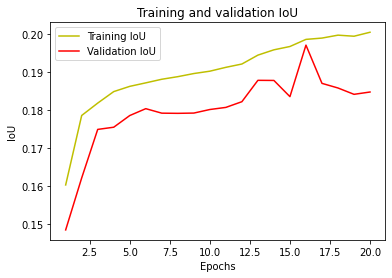

In [ ]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
%cd ..

/content/gdrive/MyDrive/project/Project


In [ ]:
#satellite_standard_unet_100epochs_7May2021.hdf5',
from keras.models import load_model
model = load_model("models/satellite_standard_unet_100epochs_7May2021.hdf5",
                   custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                   'jacard_coef':jacard_coef})

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

9/9 [==============================] - 3s 82ms/step
Mean IoU = 0.13243282


1/1 [==============================] - 1s 552ms/step


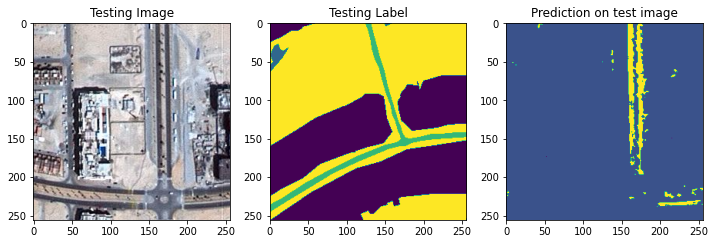

1/1 [==============================] - 0s 17ms/step


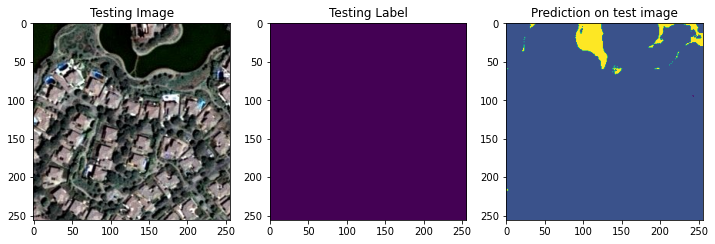

1/1 [==============================] - 0s 20ms/step


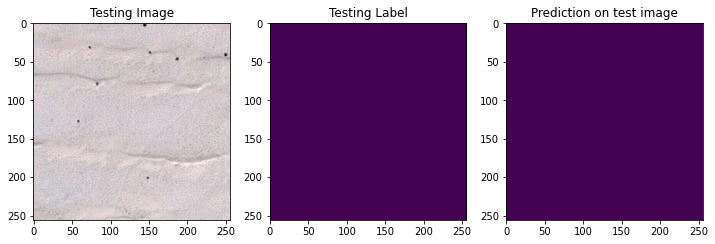

1/1 [==============================] - 0s 18ms/step


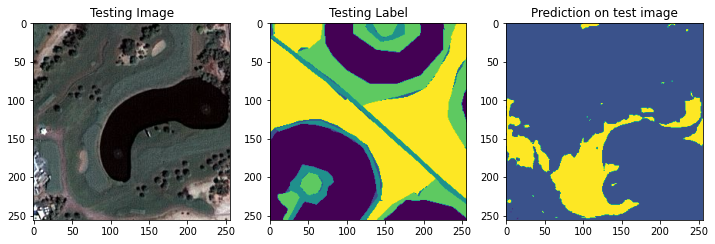

1/1 [==============================] - 0s 17ms/step


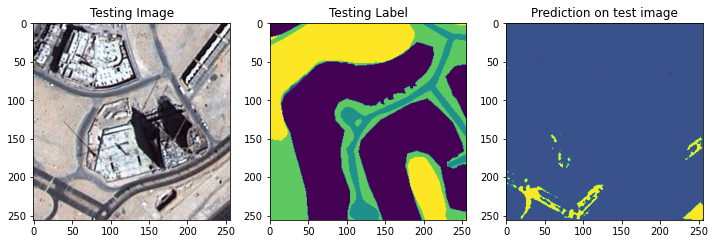

1/1 [==============================] - 0s 18ms/step


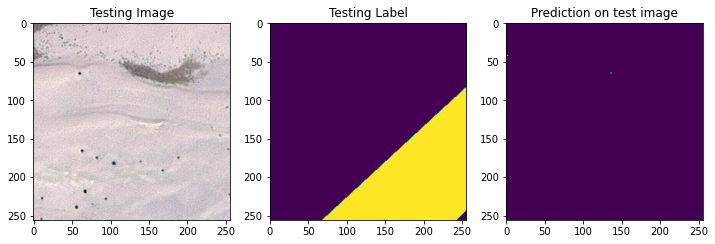

1/1 [==============================] - 0s 17ms/step


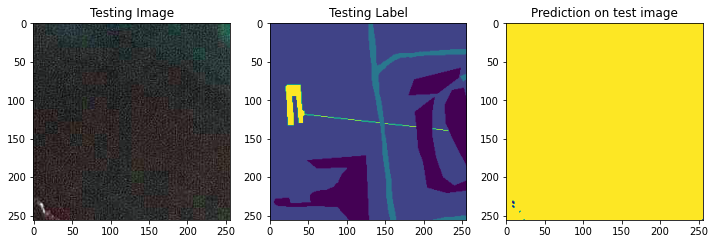

1/1 [==============================] - 0s 18ms/step


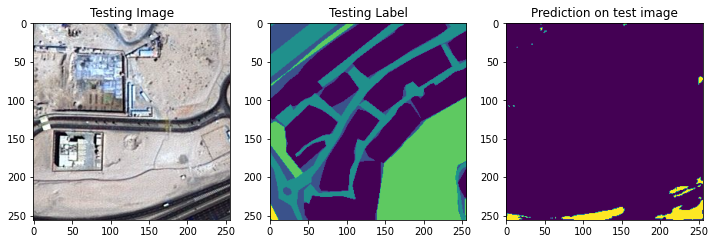

1/1 [==============================] - 0s 18ms/step


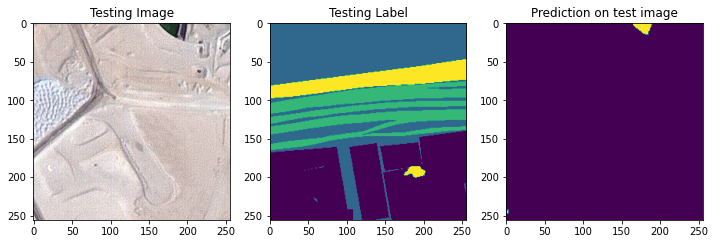

1/1 [==============================] - 0s 17ms/step


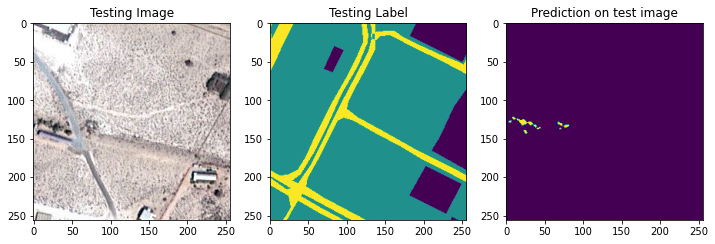

In [ ]:
#Predict on a few images

import random
#test_img_number = random.randint(0, len(X_test))
for i in range(10):
  test_img_number = i
  test_img = X_test[test_img_number]
  ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]


  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img)
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(ground_truth)
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img)
  plt.show()

In [ ]:
!python "Copy of 228_training_aerial_imagery.py"

Segmentation Models: using `keras` framework.
Now patchifying image: /content/gdrive/My Drive/SemanticSegmentation/Semantic segmentation dataset/Tile 1/images/image_part_002.jpg
Now patchifying image: /content/gdrive/My Drive/SemanticSegmentation/Semantic segmentation dataset/Tile 1/images/image_part_008.jpg
Now patchifying image: /content/gdrive/My Drive/SemanticSegmentation/Semantic segmentation dataset/Tile 1/images/image_part_006.jpg
Now patchifying image: /content/gdrive/My Drive/SemanticSegmentation/Semantic segmentation dataset/Tile 1/images/image_part_003.jpg
Now patchifying image: /content/gdrive/My Drive/SemanticSegmentation/Semantic segmentation dataset/Tile 1/images/image_part_004.jpg
Now patchifying image: /content/gdrive/My Drive/SemanticSegmentation/Semantic segmentation dataset/Tile 1/images/image_part_009.jpg
Now patchifying image: /content/gdrive/My Drive/SemanticSegmentation/Semantic segmentation dataset/Tile 1/images/image_part_005.jpg
Now patchifying image: /conten

In [8]:
%cd drive/MyDrive/project/Project/

[Errno 2] No such file or directory: 'drive/MyDrive/project/Project/'
/content/drive/MyDrive/project


In [11]:
!git checkout --


D	Copy of 228_training_aerial_imagery.py
A	Project
D	simple_multi_unet_model.py


In [ ]:
!git add  .

In [ ]:
%cd drive/MyDrive/project/Project

/content/drive/MyDrive/project/Project
